# Initial EEG data exploration

In this notebook we perform some initial data exploration. It does not have a direct link to the paper but was used to explore EEG data.

The GitHub repository of this project is available [here](https://www.github.com/pikawika/bci-master-thesis). We make use of a database provided by by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) is used. It can be downloaded from [here](https://doi.org/10.6084/m9.figshare.c.3917698.v1). Some of the code is inspired by other projects that make use of this database, if code is copied it will be clearly stated. These sources are:

- [MotorImageryPreprocessing by zafeiriou-arg](https://github.com/zafeiriou-arg/MotorImageryPreprocessing)
- [Motor Imagery Classification by sauriii98](https://github.com/sauriii98/Motor-Imagery-Classification)

## Table of Contents

- Checking requirements
    - Correct anaconda environment
    - Correct module access
    - Correct file access
- Loading in data
    - Exploring data structure
    - Classification labels
    - Making MNE object
    - Making basic plots

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on the GitHub repository of this project.

In [1]:
import os
print("Active environment: "+ os.environ['CONDA_DEFAULT_ENV'])
print("Correct environment: " + str(os.environ['CONDA_DEFAULT_ENV'] == "bci-master-thesis"))

Active environment: bci-master-thesis
Correct environment: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [2]:
# Performs IO operations
import os
import scipy.io

# Modules tailored for EEG data
import mne

# Data manipulation modules
import numpy as np
# import scipy
# import pandas as pd
# import math

# Datetime object
import datetime
import pytz

# Plotting modules
# import matplotlib.pyplot as plt

# Other helpfull modules
# import itertools
# import random




# from mne.io import RawArray
# import scipy.io
# from mne.filter import filter_data
# from scipy.stats import pearsonr
# from math import sqrt
# from scipy import signal
# from scipy.signal import butter, lfilter

<hr>

### Correct file access

The dataset provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) is used. It can be downloaded from [here](https://doi.org/10.6084/m9.figshare.c.3917698.v1). The CLA variants are used and all 16 files should be saved under a subfolder `data` of this document. Only a select few will be used for this notebook though, their filenames can be found in the vector filenames.

In [3]:
# You can specify the data directory here, per default it is under the subfolder data from this file location
data_directory = r'data/'

In [4]:
# Files needed for this notebook
filenames = ["CLA-SubjectJ-170504-3St-LRHand-Inter.mat",
            "CLA-SubjectJ-170508-3St-LRHand-Inter.mat",
            "CLA-SubjectJ-170510-3St-LRHand-Inter.mat",
            "CLASubjectA1601083StLRHand.mat",
            "CLASubjectB1510193StLRHand.mat",
            "CLASubjectB1512153StLRHand.mat"]

# Check if all files are available, if not display file name of missing file
all_files_available = True

for filename in filenames:
    if (not os.path.isfile(data_directory + filename)):
        print(data_directory + filename + "not available!")
        all_files_available = False

# Display succes message if all files are available
if (all_files_available):
    print("All files are available")
    
# Cleaning up redundant variables from this codeblock
del all_files_available
del filenames
del filename
    


All files are available


<hr><hr>

## Loading in data

In this step we load in the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. However, thanks to scipy we can get them to work in Python as well. Scipy will load in the `.mat` file as a dictionary. From the article by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) we know:

> The data in each file are represented as an instance of a Matlab structure named “o,” having the following key fields “id,” “nS,” “sampFreq,” “marker” and “data”.

Please specify the filename and metadate in the below codeblock. For more info one can look at the `data\Data_description.txt` file.

In [5]:
# You can specify the data file to use here, per default it is CLASubjectA1601083StLRHand.mat
data_file_name = r'CLASubjectA1601083StLRHand.mat'

# Specify the metadata
data_meta_date = datetime.datetime(2016, 1, 8, 0, 0, 0, 0, pytz.UTC).timestamp()
data_meta_sex = 1 # 0=unknown, 1=male, 2=female
data_meta_age = "20 - 25"

# Correct date format
data_meta_date = datetime.datetime.fromtimestamp(data_meta_date,tz=datetime.timezone.utc)

In [6]:
# Load in the file
data_raw_full = scipy.io.loadmat(data_directory + data_file_name, struct_as_record=False, squeeze_me=True)

# show keys of the dictionary
print(data_raw_full.keys())

# The data is stored inside the matlab structure named "o"
data_raw = data_raw_full['o']

# Cleaning up redundant variables from this codeblock
del data_raw_full

dict_keys(['__header__', '__version__', '__globals__', 'o'])


<hr>

### Exploring data structure

The following data is available:

- id: A unique alphanumeric identifier of the record
- tag: Unknown field
   - Was not specified in article
- binsuV: Probably bins per microvolt
   - Was not specified in article
- nS: Number of EEG data samples
- sampFreq: Sampling frequency of the EEG data
- marker: The eGUI interaction record of the recording session
- chnames: Probably channel names of the EEG data sensors/channels in 10/20 configuration
   - Was not specified in article
- data: The Raw EEG data of the recording session

In [7]:
# We can now access the data in a MATLAB like fashion thanks to the configuration of loadmat
print("id: " + str(data_raw.id))
print()
print("tag: " + str(data_raw.tag))
print()
print("binsuV: " + str(data_raw.binsuV))
print()
print("nS: " + str(data_raw.nS))
print()
print("sampFreq: " + str(data_raw.sampFreq))
print()
print("marker: " + str(data_raw.marker))
print("marker shape: " + str(data_raw.marker.shape))
print()
print("chnames: " + str(data_raw.chnames))
print("chnames shape: " + str(data_raw.chnames.shape))
print()
print("data: " + str(data_raw.data))
print("data shape: " + str(data_raw.data.shape))

id: 201601081851.951FEF1D

tag: NK-data import (auto)

binsuV: 1

nS: 671600

sampFreq: 200

marker: [0 0 0 ... 0 0 0]
marker shape: (671600,)

chnames: ['Fp1' 'Fp2' 'F3' 'F4' 'C3' 'C4' 'P3' 'P4' 'O1' 'O2' 'A1' 'A2' 'F7' 'F8'
 'T3' 'T4' 'T5' 'T6' 'Fz' 'Cz' 'Pz' 'X5']
chnames shape: (22,)

data: [[ -0.    -0.    -0.   ...  -0.    -0.    -0.  ]
 [ -0.    -0.    -0.   ...  -0.    -0.    -0.  ]
 [ -0.    -0.    -0.   ...  -0.    -0.    -0.  ]
 ...
 [ 23.8  -28.4    4.31 ...  -8.31  -6.    -0.23]
 [ 10.74 -37.39   5.51 ...  -9.34  -5.99  -0.16]
 [  0.76 -47.95   3.66 ...  -7.32  -4.9   -0.41]]
data shape: (671600, 22)


In [8]:
# If all is correct the following should make sense
print("Amount of channel names correspond with amount of channels available(" + str(data_raw.data.shape[1]) +") " + str(data_raw.chnames.size == data_raw.data.shape[1]))

print("Number of samples corresponds with amount of data records (" + str(data_raw.data.shape[0]) +"): " + str(data_raw.nS == data_raw.data.shape[0]))

Amount of channel names correspond with amount of channels available(22) True
Number of samples corresponds with amount of data records (671600): True


<hr>

### Classification labels

From the article by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) we know:

>The “marker” field contains the recording sessions’ interaction record. This record is in the form of 1D
Matlab array of size nSx1, which contains integer values from 0 to 99. Each value encodes the state of the
eGUI at the time mapping to the corresponding EEG data sample in the “data” array at the same timeindex location.

We see the following codes in the CLA datasets:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand
    - EEG data for MI of left hand
- 2: Right hand action
    - EEG data for MI of right hand
- 3: Passive/neutral
    - EEG data for MI of neither left or right hand

In [9]:
unique, counts = np.unique(data_raw.marker, return_counts=True)
dict(zip(unique, counts))

{0: 476168, 1: 61490, 2: 69202, 3: 64740}

<hr>

### Making MNE object

Having access to all of the data, we can manually make MNE-Python data structures per specification of the [MNE documentation](https://mne.tools/dev/auto_tutorials/simulation/10_array_objs.html). This consist of first making an `MNE info` object which can then be used to create a `raw MNE` object.

#### Making info object

From the article by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) we know that:
> The EEG data acquisition was performed with the help of a standard 10/20 EEG cap (Electro-Cap
International, USA) with 19 bridge electrodes in the 10/20 international configuration.

However, we see 22 channels are present, and the 10/20 configuration only has 21 channels. We remove the unkown one from the data, namely `X5`.

<div>
    <img src="images/10-20.svg" width="300"/>
    <center><small>By トマトン124 (talk) - Own work, Public Domain, https://commons.wikimedia.org/w/index.php?curid=10489987</small></center>
</div>

In [10]:
# Check the present channels, and conclude X5 is not in 10/20 convention
data_raw.chnames

array(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'A1',
       'A2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'X5'],
      dtype=object)

In [11]:
# Remove X5 (last element) from the channel names and use it as input for the info object
mne_ch_names = data_raw.chnames.tolist()
mne_ch_names.pop(-1)

# All of the sensors are EEG
mne_ch_types = ['eeg'] * len(mne_ch_names)

# The sampling frequency is given
mne_sfreq = data_raw.sampFreq

# Create info object
mne_info = mne.create_info(ch_names=mne_ch_names, ch_types=mne_ch_types, sfreq=mne_sfreq)

# Configure it to be the 10/20 convention
mne_info.set_montage('standard_1020')

# Set some other meta fields
mne_info['description'] = 'Data from ' + data_file_name
mne_info['experimenter'] = 'Kaya et al.'
mne_info['meas_date'] = data_meta_date
mne_info['subject_info'] = {
    "his_id": data_raw.id,
    "sex": data_meta_sex
}

# Cleaning up redundant variables from this codeblock
del mne_ch_names
del mne_ch_types
del mne_sfreq


# Show the info object
print(mne_info)
mne_info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from CLASubjectA1601083StLRHand.mat
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2016-01-08 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from CLASubjectA1601083StLRHand.mat
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2016-01-08 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

#### Making raw object

Having the info object, we can create the raw object. First we need to alter the data a bit so the `X5` channel is removed and the matrix is transposed.

In [12]:
# Removing X5
mne_raw_data = data_raw.data
print("Before X5 remove (last element)")
print(mne_raw_data.shape)
print(mne_raw_data[1100])
print()

mne_raw_data = mne_raw_data[:, :-1]
print("After X5 remove (last element)")
print(mne_raw_data.shape)
print(mne_raw_data[1100])

Before X5 remove (last element)
(671600, 22)
[ -0.9   25.43  -0.19   7.1   -0.64   1.06  -1.82  -2.7  -11.52  -8.27
  10.27  12.97  -1.99   9.13   3.67   1.35  -2.11  -0.46   6.     0.81
  -5.58  -0.17]

After X5 remove (last element)
(671600, 21)
[ -0.9   25.43  -0.19   7.1   -0.64   1.06  -1.82  -2.7  -11.52  -8.27
  10.27  12.97  -1.99   9.13   3.67   1.35  -2.11  -0.46   6.     0.81
  -5.58]


In [13]:
# Transposing
print("Before transpose")
print(mne_raw_data.shape)
print("Random element: " + str(mne_raw_data[1100][2]))
print()

mne_raw_data = mne_raw_data.transpose()
print("After transpose")
print(mne_raw_data.shape)
print("Same random element: " + str(mne_raw_data[2][1100]))

Before transpose
(671600, 21)
Random element: -0.19

After transpose
(21, 671600)
Same random element: -0.19


In [14]:
# Creating MNE array
mne_raw = mne.io.RawArray(mne_raw_data, mne_info)

# Cleaning up redundant variables from this codeblock
del mne_raw_data
del mne_info

Creating RawArray with float64 data, n_channels=21, n_times=671600
    Range : 0 ... 671599 =      0.000 ...  3357.995 secs
Ready.


<hr>

### Making basic plots

Having the raw data we should be able to make some basic plots to validate the data seems loaded in properly. We try this here.

plot_sensors


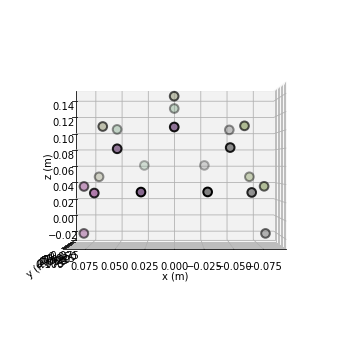

plot_psd
Effective window size : 10.240 (s)


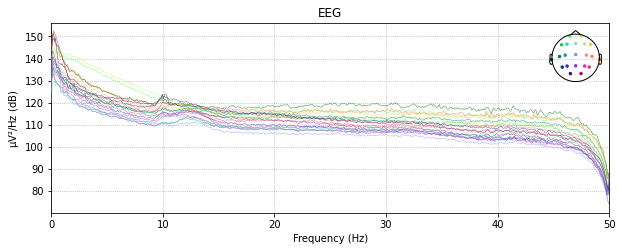

plot


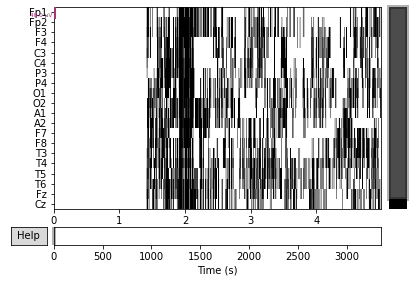

done plotting


In [15]:
# Make some plots
print("plot_sensors")
mne_raw.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

print("plot_psd")
mne_raw.plot_psd(fmax=50)

print("plot")
mne_raw.plot(duration=5)

print("done plotting")